# 第五章 时序差分价值迭代

* 直接利用经验数据学习，不需要环境模型
* 采用动态规划中自益的思想，用现有价值估计值来更新价值估计

In [5]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import gym

## 使用环境： 的士调度Taxi-v3

In [6]:
env = gym.make("Taxi-v3")
env.seed(0)
print("观测空间 = {}".format(env.observation_space))
print("动作空间 = {}".format(env.action_space))
print("状态数量 = {}".format(env.observation_space.n))
print("动作数量 = {}".format(env.action_space.n))

观测空间 = Discrete(500)
动作空间 = Discrete(6)
状态数量 = 500
动作数量 = 6


In [7]:
state = env.reset()
taxirow, taxicol, passloc, destidx = env.unwrapped.decode(state)
print(taxirow, taxicol, passloc, destidx)
print("的士位置 = {}".format((taxirow, taxicol)))
print("乘客位置 = {}".format(env.unwrapped.locs[passloc]))
print("目标位置 = {}".format(env.unwrapped.locs[destidx]))
env.render()

0 1 1 2
的士位置 = (0, 1)
乘客位置 = (0, 4)
目标位置 = (4, 0)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [8]:
action = np.random.choice(env.action_space.n)
print("action = {}".format(action))
env.step(action)
env.render()

action = 4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


## 同策时序差分迭代

* 推导：

  > $$
  > \begin{aligned}
  > q_\pi(s,a) &= E_\pi[ G_t | S_t = s, A_t = a ]\\
  > &= E_\pi[ R_{t+1} + \gamma G_{t+1} | S_t = s, A_t = a ]\\
  > &= E_\pi[ R_{t+1} + \gamma q_\pi(S_{t+1},A_{t+1}) | S_t = s, A_t = a ]\\
  > \end{aligned}
  > $$

  单步时序差分更新只采样一步，进而用$U_{t} = R_{t+1} + \gamma q_\pi(S_{t+1},A_{t+1})$来估计回报样本的值。

  用$U_t$表示使用自益得到的有偏回报样本

* 【**时序差分目标**】

  * <u>针对动作价值</u>：$U_{t:t+1}^{(q)} = R_{t+1} + \gamma q(S_{t+1},A_{t+1})$

    > 上标的$(q)$：表示为动作价值
    >
    > 下标的$t:t+1$：用$t+1$时的状态动作对估计$t$时刻的状态动作对
    >
    > 若$S_{t+1}$时终止状态，默认$q(S_{t+1},\cdot) = 0$

    n步时序差分目标：$U_{t:t+n}^{(q)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n q(S_{t+n},A_{t+n})$

    不强调步数时简记为$U_{t}^{(q)}$或$U_t$。若回合步数$T \le t + n$，泽科强制让$R_t = 0, S_t = S_{终止}$。此时时序差分目标仍然成立，实际上达到了
    $$
    U_{t:t+n}^{(q)} = \begin{cases}
    R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n q(S_{t+n},A_{t+n}), &t+n \le T\\
    R_{t+1} + \gamma R_{t+2} + \dots+\gamma^{T-t-1}R_T,&t+n \ge T
    \end{cases}
    $$

  * <u>针对状态价值</u>：$U_{t:t+n}^{(v)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n v(S_{t+n})$

### 时序差分更新策略评估

> 回顾同策回合更新策略评估，我们用形如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ G_t - q(S_t,A_t) ]$的增量来更新学习动作价值函数，试图减小$[G_t - q(S_t,A_t)]^2$。时序差分中$G_t$对应$U_t$

#### 单步时序差分更新评估策略的动作价值

【输入】环境（无数学描述）、策略$\pi$

【输出】动作价值函数$q(s,a)$，$s\in S, a \in A$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 初始化状态动作对：选择状态$S$，在根据策略确定动作$A$
   2. 若回合未结束（如未达最大步数、$S$不是终止状态）则执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      2. 用输入策略$\pi$确定动作$A'$
      3. 计算回报的估计值$U \leftarrow R +\gamma q(S',A')$
      4. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      5. $S \leftarrow S',A \leftarrow A'$

【补充】在回合更新中，学习率为$1/c(S_t,A_t)$。其与状态动作对有关，且不断减小。时序差分更新中学习率可不断减小，但是由于价值函数越来越精确，估计值的权重也可越来越大。也可采用固定的学习率

#### 单步时序差分更新评估策略的状态价值

【输入】环境（无数学描述）、策略$\pi$

【输出】状态价值函数$v(s)$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$v(s)\leftarrow any$，若有终止状态$v(s_{终止}) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 初始化状态：选择状态$S$
   2. 若回合未结束（如未达最大步数、$S$不是终止状态）则执行以下操作：
      1. 用输入策略$\pi$确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      3. 计算回报的估计值$U \leftarrow R +\gamma v(S')$
      4. 更新$v(S)$以减小$[U - v(S)]^2$，如$v(S) \leftarrow v(S) +\alpha[U - v(S)]$
      5. $S \leftarrow S'$

#### 回合更新和时序差分

* 无模型情况下回合更新和时序差分更新都可渐近与真实的价值函数，根据经验在学习率同为常数的情况下时序差分比回合更新更快收敛，但是时序差分对Markov性的要求更高

* 例：$s_A,0 \to s_B,0;s_A,0 \to s_A,1 \to s_B,0;s_A,0 \to s_A,1$

  回合更新：$v(s_A) = \frac25,v(s_B) = 0$；时序差分$v(s_A) = v(s_B) = \frac25$

  回合更新只考虑含有$s_B$的轨迹样本，用这两个轨迹样本回报来估计状态价值

  时序差分更新认为$s_B$一定会到$s_A$，所以可以利用全部轨迹样本来估计$v(s_A)$，进而由$v(s_A)$推出$v(s_B)$

* 如果此环境为Markov决策过程，状态空间$S = \{s_A,s_B\}$，则时序差分更新用到了整个轨迹来估计$v(s_B)$，可以得到更精确的估计

* 如果此环境不为Markov决策过程，或$\{s_A,s_B\}$不为真正的状态空间，则可能$s_A$之后获得的奖励值其实和这个轨迹是否到达过$s_B$有关，采用回合更新可以不受此错误的影响

#### n步时序差分更新评估策略的动作价值

【输入】环境（无数学描述）、策略$\pi$

【输出】动作价值函数$q(s,a)$，$s\in S, a \in A$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 生成n步：用策略$\pi$生成轨迹$S_0,A_0,R_1,\dots,R_n,S_n$（若遇终止状态则令后续奖励全部为0，状态全部为$s_{终止}$）
   2. 对$t = 0,1,2,\dots$，依次执行以下操作，直到$S_t = s_{终止}$：
      1. 若$S_{t+n} \ne s_{终止}$，则据$\pi(\cdot|S_{t+n})$决定动作$A_{t+n}$
      2. 更新时序差分目标：$U_{t:t+n}^{(q)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n q(S_{t+n},A_{t+n})$
      3. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      4. 若$S_{t+n} \ne s_{终止}$，则执行$A_{t+n}$得到奖励$R_{t+n+1}$和下一状态$S_{t+n+1}$；若$S_{t+n} = s_{终止}$则令$R_{t+n+1} \leftarrow 0,S_{t+n+1} \leftarrow s_{终止}$

#### n步时序差分更新评估策略的状态价值

【输入】环境（无数学描述）、策略$\pi$

【输出】状态价值函数$v(s)$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$v(s)\leftarrow any$，若有终止状态$v(s_{终止}) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 生成n步：用策略$\pi$生成轨迹$S_0,A_0,R_1,\dots,R_n,S_n$（若遇终止状态则令后续奖励全部为0，状态全部为$s_{终止}$）
   2. 对$t = 0,1,2,\dots$，依次执行以下操作，直到$S_t = s_{终止}$：
      1. 更新时序差分目标：$U_{t:t+n}^{(v)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n v(S_{t+n})$
      2. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      3. 若$S_{t+n} \ne s_{终止}$，则据$\pi(\cdot|S_{t+n})$决定动作$A_{t+n}$并执行，得到奖励$R_{t+n+1}$和下一状态$S_{t+n+1}$；若$S_{t+n} = s_{终止}$则令$R_{t+n+1} \leftarrow 0,S_{t+n+1} \leftarrow s_{终止}$



### SARSA算法

* 采用同策时序差分更新来求解最优策略
* 更新设计的变量：$(S_t,A_t,R_{t+1},S_{t+1},A_{t+1})$
* 利用$U_t = R_{t+1} +\gamma q(S_{t+1},A_{t+1})$

#### SARSA算法求解最优策略（显式更新策略）

【输入】环境（无数学描述）

【输出】最优策略估计$\pi(a|s)$和最优动作价值估计$q(s,a)$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，策略改进的参数（如$\varepsilon$），控制回合数和回合内步数的参数

1. 初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$。用动作价值$q(s,a)$确定策略$\pi$（如$\varepsilon$贪心策略）
2. 时序差分更新：对每个回合进行以下操作
   1. 初始化状态动作对：选择状态$S$，在根据策略确定动作$A$
   2. 若回合未结束（如未达最大步数、$S$不是终止状态）则执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      2. 用输入策略$\pi$确定动作$A'$
      3. 计算回报的估计值$U \leftarrow R +\gamma q(S',A')$
      4. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      5. 策略改进：据$q(S|\cdot)$改进策略$\pi(\cdot|S)$（如$\varepsilon$贪心策略）
      6. $S \leftarrow S',A \leftarrow A'$

**SARSA算法就是在单步动作价值估计的算法的基础上，在更新价值估计后更新策略**

#### SARSA算法求解最优策略（中间过程不显式存储最优策略）

*在没有显式存储的情况下，最优动作价值估计已经隐含了$\varepsilon$柔性策略，利用此柔性策略可以确定出动作$A$。例如用$\varepsilon$贪心策略决定某个状态$S$的动作时，可以先生成一个$[0,1]$上均匀分布的随机变量$X$，若$X < \varepsilon$则进行探索，随机选择动作，否则选择让$q(S,\cdot)$最大的动作*

【输入】环境（无数学描述）、策略$\pi$

【输出】最优动作价值估计$q(s,a)$，$s\in S, a \in A$。用此可轻易得到最优策略估计

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 初始化状态动作对：选择状态$S$，在根据策略确定动作$A$
   2. 若回合未结束（如未达最大步数、$S$不是终止状态）则执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      2. 用输入策略$\pi$确定动作$A'$
      3. 计算回报的估计值$U \leftarrow R +\gamma q(S',A')$
      4. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      5. $S \leftarrow S',A \leftarrow A'$

#### n步SARSA算法求解最优策略

【输入】环境（无数学描述）、策略$\pi$

【输出】最优动作价值估计$q(s,a)$，$s\in S, a \in A$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 生成n步：根据动作价值估计$q$确定的策略$\pi$生成轨迹$S_0,A_0,R_1,\dots,R_n,S_n$（若遇终止状态则令后续奖励全部为0，状态全部为$s_{终止}$）
   2. 对$t = 0,1,2,\dots$，依次执行以下操作，直到$S_t = s_{终止}$：
      1. 若$S_{t+n} \ne s_{终止}$，则据$\pi(\cdot|S_{t+n})$决定动作$A_{t+n}$
      2. 更新时序差分目标：$U_{t:t+n}^{(q)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n q(S_{t+n},A_{t+n})$
      3. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      4. 若$S_{t+n} \ne s_{终止}$，则执行$A_{t+n}$得到奖励$R_{t+n+1}$和下一状态$S_{t+n+1}$；若$S_{t+n} = s_{终止}$则令$R_{t+n+1} \leftarrow 0,S_{t+n+1} \leftarrow s_{终止}$


In [9]:
class SARSAAgent:
    def __init__(self, env, gamma=0.9, lr=0.2, epsilon=0.01):
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
    
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done, next_action):
        u = reward + self.gamma * self.q[next_state, next_action] * (1 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.lr * td_error

In [10]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) 
        if train:
            agent.learn(observation, action, reward, next_observation, 
                        done, next_action)
        if done:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = 811 / 100 = 8.11


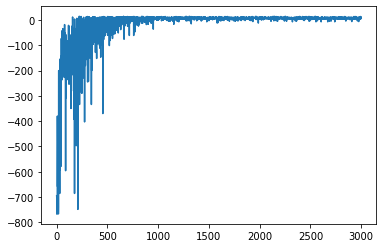

In [11]:
agent = SARSAAgent(env)

# 训练
episodes = 3000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print("平均回合奖励 = {} / {} = {}".format(sum(episode_rewards),
                len(episode_rewards), np.mean(episode_rewards)))

In [12]:
# 显示最优价值估计
pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.917114,-2.413514,-3.891059,-3.856296,1.077944,-5.597004
2,-2.890228,-2.967669,-2.470134,-3.013133,3.935491,-3.636000
3,-3.750222,-3.824270,-3.736722,-3.625218,1.737983,-4.415685
4,-5.906131,-5.969242,-5.959491,-6.042813,-7.071601,-7.118850
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.832437,-2.920107,-2.864830,-2.915254,-3.600000,-3.636000
497,-1.367957,-1.385335,-1.389302,-1.422816,-3.600000,-3.636000
498,-3.212856,-3.115219,-3.172509,-3.030390,-5.069730,-3.636000


In [13]:
# 显示最优策略估计
policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,1.0,0.0,0.0,0.0,0.0,0.0
497,1.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0


#### 期望SARSA求解最优策略

1. 初始化：初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$，动作价值$q(s,a)$确定策略$\pi$（如$\varepsilon$贪心策略）
2. 时序差分更新：对每个回合进行以下操作
   1. 初始化状态：选择状态$S$
   2. 若回合未结束（比如未达到最大步数，$S$不是终止状态），执行以下操作：
      1. 用动作价值$q$确定的策略（如$\varepsilon$贪心）确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      3. 用期望计算回报的估计值：$U \leftarrow R +\gamma \sum_{a \in A(S')} \pi(a|S')q(S',a)$
      4. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      5. $S \leftarrow S'$

#### 多步期望SARSA求解最优策略

1. 初始化：初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合进行以下操作
   1. 生成n步：根据动作价值估计$q$确定的策略$\pi$生成轨迹$S_0,A_0,R_1,\dots,R_n,S_n$（若遇终止状态则令后续奖励全部为0，状态全部为$s_{终止}$）
   2. 对$t = 0,1,2,\dots$，依次执行以下操作，直到$S_t = s_{终止}$：
      1. 更新时序差分目标：$U \leftarrow R_{t+1} +\gamma R_{t+1} + \dots +\gamma^{n-1} R_{t+n} + \gamma^n \sum_{a \in A(S_{t+n})} \pi(a|S_{t+n})q(S_{t+n},a)$
      2. 更新价值：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      3. 若$S_{t+n} \ne s_{终止}$，则执行$A_{t+n}$得到奖励$R_{t+n+1}$和下一状态$S_{t+n+1}$；若$S_{t+n} = s_{终止}$则令$R_{t+n+1} \leftarrow 0,S_{t+n+1} \leftarrow s_{终止}$

In [17]:
class ExpectedSARSAAgent:
    def __init__(self, env, gamma=0.9, lr=0.1, epsilon=0.01):
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_n = env.action_space.n

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done):
        # epsilon贪心策略的数学表述
        v = (self.q[next_state].mean() * self.epsilon + \
            self.q[next_state].max() * (1 - self.epsilon))
        u = reward + self.gamma * v * (1 - done)
        td_error = u - self.q[state,action]
        self.q[state,action] += self.lr * td_error

In [18]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation, done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = 788 / 100 = 7.88


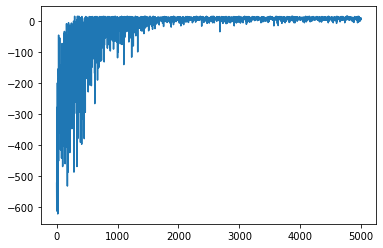

In [20]:
agent = ExpectedSARSAAgent(env)

# train
episodes = 5000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# test
agent.epsilon = 0.
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

## 异策时序差分更新

### 基于重要性采样的异策算法

* 重要性采样比率：$\rho_{t+1:t+n-1} = \prod_{\tau = t+1}^{t+n-1}\frac{\pi(A_\tau|S_\tau)}{b(A_\tau|S_\tau)}$

#### 重要性采样n步时序差分策略评估动作价值或SARSA算法

【输入】环境（无数学描述），策略$\pi$

【输出】动作价值函数$q(s,a)$，若是最优策略控制还要输出策略$\pi$

【参数】步数n，优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$，若是最优策略控制，还应该用$q$决定$\pi$（如$\varepsilon$贪心）
2. 时序差分更新：对每个回合执行以下操作
   1. 行为策略：指定行为策略$b$使得$\pi \ll b$
   2. 生成n步：用策略$b$生成轨迹$S_0,A_0,R_1,\dots,R_n,S_n$（若遇终止状态则令后续奖励全部为0，状态全部为$s_{终止}$）
   3. 对$t = 0,1,2,\dots$，依次执行以下操作，直到$S_t = s_{终止}$：
      1. 若$S_{t+n} \ne s_{终止}$，则根据$\pi(\cdot|S_{t+n})$决定策略$A_{t+n}$
      2. 更新时序差分目标：$U_{t:t+n}^{(q)} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^n q(S_{t+n},A_{t+n})$
      3. 计算重要性采样比率$\rho_{t+1:t+n-1}$：$\rho \leftarrow \prod_{\tau=t+1}^{\min(t+n,T)-1}\frac{\pi(A_\tau|S_\tau)}{b(A_\tau|S_\tau)}$
      4. 更新价值：更新$q(S,A)$以减小$\rho[U_t - q(S,A)]^2$
      5. 更新策略：若是最优策略求解算法，需要根据$q(S_t,\cdot)$修改$\pi(\cdot|S)$
      6. 若$S_{t+n} \ne s_{终止}$，则执行$A_{t+n}$，得到奖励$R_{t+n+1}$和下一状态$S_{t+n+1}$。若$S_{t+n} = s_{终止}$则令$R_{t+n+1} \leftarrow 0,S_{t+n+1} \leftarrow s_{终止}$

*类似地，也可用于状态价值估计*

### Q学习

从改进后的策略出发，将时序差分目标改为：
$$
U_t = R_{t+1} +\gamma \max_{a\in A(S_{t+1})} q(S_{t+1},a)
$$
Q学习算法认为，在根据$S_{t+1}$估计$U_t$时，与其使用$q(S_{t+1},A_{t+1})$或$v(S_{t+1})$还不如使用根据$q(S_{t+1},\cdot)$改进后的策略来更新，这样可以接近最优价值。

Q学习的更新式不是基于当前策略，而是基于另一个不一定要使用的确定性策略来更新工作价值。

多步版本：$U = R_{t+1} +\gamma R_{t+1} + \dots +\gamma^{n-1} R_{t+n} + \gamma^n \max_{a\in A(S_{t+n})} q(S_{t+n},a)$

#### Q算法求解最优策略

1. 初始化：初始化：$q(s,a)\leftarrow any$，若有终止状态$q(s_{终止},a) \leftarrow 0$
2. 时序差分更新：对每个回合执行以下操作
   1. 初始化状态：选择状态$S$
   2. 若回合未结束（比如未达到最大步数，$S$不是终止状态），执行以下操作：\
      1. 用动作价值$q$确定的策略（如$\varepsilon$贪心）确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      3. 用改进后的策略计算回报的估计值：$U \leftarrow R + \gamma \max_{a\in A(s')} q(S',a)$
      4. 更新价值和策略：更新$q(S,A)$以减小$[U_t - q(S,A)]^2$，如$q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha [ U_t - q(S_t,A_t) ]$
      5. $S \leftarrow S'$

In [22]:
class QLearningAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.01):
        self.gamma = gamma
        self.lr = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
    
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done):
        u = reward + self.gamma * self.q[next_state].max() * (1 - done)
        td_error = u - self.q[state, action]
        self.q[state,action] += self.lr * td_error

平均回合奖励 = 615 / 100 = 6.15


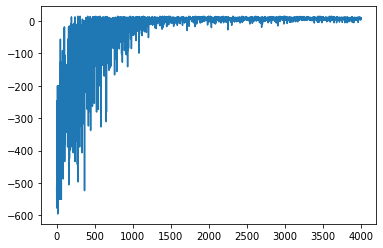

In [23]:
agent = QLearningAgent(env)

# 训练
episodes = 4000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 双重Q学习

Q学习采用$\max q$来更新动作价值，会导致最大化偏差，使得估计得到的动作价值偏大。

双重Q学习采用两个独立动作价值估计值$q^{(0)}(\cdot,\cdot)$和$q^{(1)}(\cdot,\cdot)$，用$q^{(0)}(S_{t+1},q^{(1)}(S_{t+1},a))$或$q^{(1)}(S_{t+1},q^{(0)}(S_{t+1},a))$来代替Q学习中的$\max_a q(S_{t+1},a)$。由于$q^{(0)}$和$q^{(1)}$是相互独立的估计，所以$E[q^{(0)}(S_{t+1},A^*)] = q(S_{t+1},A^*), A^* = \mathop{\arg\max}_a q^{(1)}(S_{t+1},a)$，因此可消除偏差。

在双重学习的过程中，$q^{(0)}$和$q^{(1)}$都需要逐步更新，因此每步学习都可以等概率选择以下两个更新中的任意一个：

1. 使用$U_t^{(0)} = R_{t+1} + \gamma q^{(1)}(S_{t+1},\mathop{\arg\max}_a q^{(0)}(S_{t+1},a))$来更新$(S_t,A_t)$，以减小$U_t^{(0)}$和$q^{(0)}(S_t,A_t)$之间的差别
2. 使用$U_t^{(1)} = R_{t+1} + \gamma q^{(0)}(S_{t+1},\mathop{\arg\max}_a q^{(1)}(S_{t+1},a))$来更新$(S_t,A_t)$，以减小$U_t^{(1)}$和$q^{(1)}(S_t,A_t)$之间的差别

#### 双重Q学习算法求解最优策略

1. 初始化：初始化：$q^{(i)}(s,a)\leftarrow any$，若有终止状态$q^{(i)}(s_{终止},a) \leftarrow 0$

2. 时序差分更新：对每个回合执行以下操作
   1. 初始化状态：选择状态$S$
   2. 若回合未结束（比如未达到最大步数，$S$不是终止状态），执行以下操作：
      1. 用动作价值$\left(q^{(0)} +q^{(1)}\right)(S,\cdot)$确定的策略（如$\varepsilon$贪心）确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      3. 随机选择更新$q^{(0)}，q^{(1)}$：等概率选择$q^{(0)},q^{(1)}$中的一个动作价值函数作为新对象，记选择的是$q^{(i)}$
      4. 用改进后的策略更新回报的估计：$U \leftarrow R +\gamma q^{(1-i)}(S',\mathop{\arg\max}_a q^{(i)})(S',a)$
      5. 更新动作价值：$q^{(i)}(S,A)$以减小$[U - q^{(i)}(S,A)]^2$
      6. $S \leftarrow S'$

In [26]:
class DoubleQLearningAgent:
    def __init__(self, env, gamma = 0.9, lr = 0.1, epsilon = 0.01):
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q0 = np.zeros((env.observation_space.n, env.action_space.n))
        self.q1 = np.zeros((env.observation_space.n, env.action_space.n))

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = (self.q0 + self.q1)[state].argmax()     
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done):
        if np.random.randint(2):
            self.q0, self.q1 = self.q1, self.q0
            a = self.q0[next_state].argmax()
            u = reward + self.gamma * self.q1[next_state, a] * (1 - done)
            td_error = u - self.q0[state, action]
            self.q0[state, action] += self.lr* td_error  

平均回合奖励 = 201 / 100 = 2.01


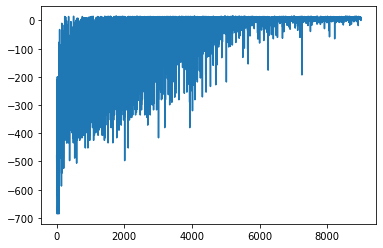

In [29]:
agent = DoubleQLearningAgent(env)

# 训练
episodes = 9000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

## 资格迹

### $\lambda$回报

【$\lambda$**回报**】时序差分目标$U_{t:t+1},U_{t:t+2},U_{t:t+3},\dots$按$(1-\lambda),(1-\lambda)\lambda,(1-\lambda)\lambda^2,\dots$加权平均的结果。其中$\lambda \in [0,1]$

* 对于连续性任务：$U_t^\lambda = (1 - \lambda)\sum_{n=1}^{+\infty} U_{t:t+n}$
* 对于回合制任务：$U_t^\lambda = (1 - \lambda)\sum_{n=1}^{T-t-1} \lambda^{n-1}U_{t:t+n} + \lambda^{T-t-1}G_t$

$\lambda$回报可以看为回合更新中的目标$G_t$和时序差分目标$U_t$的推广。$\lambda = 1$时则为回合更新的回报；$\lambda=0$时则为单步时序差分目标

【**离线$\lambda$回报算法**】更新价值时用$U_t^\lambda$作为目标，与回合更新算法相比只是将$G_t$换为$U_t^\lambda$

对于回合制任务，在回合结束后为每一步计算$U_t^\lambda$并统一更新价值，这样的算法称为**离线算法**。对于连续性任务，无法计算$U_t^\lambda$，因此无法使用离线$\lambda$离线算法

* 优点：在$G_t$和$U_{t:t+1}$之间折中，效果更好
* 缺点：只能用于回合制任务，不能用于连续性任务；回合结束后要计算$U_t^\lambda$，计算量巨大

### $\mathrm{TD}(\lambda)$

【**资格迹**】表示第$t$步的状态动作对的单步自益结果对每个状态动作对需要更新的权重

* $e_0(s,a) = 0, s \in S, a\in A,t = 0$
* $e_t = \begin{cases}  1 +\beta\gamma\lambda e_{t-1}(s,a),&S_t=s,A_t=a\\ \gamma\lambda e_{t-1}(s,a),&others  \end{cases},t > 0$，其中$\beta \in [0,1]$为给定参数
* 理解：对于历史上某个状态动作对$(S_\tau,A_\tau)$，距离第$t$步间隔了$t-\tau$步。$U_{\tau:t}$在$\lambda$回报中的权重为$(1-\lambda)\lambda^{t-\tau-1}$，并且$U_{\tau:t} = R_{\tau+1}+ \dots + \gamma^{t-\tau-1}U_{t-1:t}$，所以$U_{t-1:t}$以$(1-\lambda)(\lambda\gamma)^{t-\tau-1}$的比率折算到$U_\tau^\lambda$中。间隔的步数增加异步，原先的资格迹大致需要衰减为$\gamma\lambda$倍，对当前最新出现的状态动作对的更新权重则需要进行某种强化。强化的强度$\beta$常有以下取值：
  1. $\beta = 1$：累积迹，资格迹直接加一
  2. $\beta = 1- \alpha$：荷兰迹，增加的幅度在$\beta = 0$和$\beta = 1$之间
  3. $\beta = 0$：替换迹，资格迹总是在0到1之间

#### $\mathrm{TD}(\lambda)$的动作价值评估或$\mathrm{SARSA}(\lambda)$学习

【输入】环境，无数学描述；若评估动作价值则需要输入策略$\pi$

【输出】动作价值估计$q(s,a)$

【参数】资格迹参数$\beta$，优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：初始化：$q^{(i)}(s,a)\leftarrow any$，若有终止状态$q^{(i)}(s_{终止},a) \leftarrow 0$

2. 对每个回合执行以下操作

   1. 初始化资格迹：$e(s,a) \leftarrow 0$
   2. 初始化状态动作对：选择状态$S$，根据策略确定动作$A$
   3. 若回合未结束（比如未达到最大步数，$S$不是终止状态），执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和新状态$S'$
      2. 根据策略或最优价值函数确定动作$A'$
      3. 更新资格迹：$e(s,a) \leftarrow \gamma\lambda e(s,a), e(s,a) \leftarrow 1 + \beta e(s,a)$
      4. 计算回报的估计值：$U \leftarrow R + \gamma q(S',A')$
      5. 更新价值：$q(s,a) \leftarrow q(s,a) + \alpha e(s,a)[U - q(S,A)]$
      6. 若$S' = s_{终止}$则退出，否则$S \leftarrow S',A \leftarrow A'$

   状态价值同理。

   $\mathrm{TD}(\lambda)$与离线$\lambda$算法相比：

   1. 既可用于回合制任务，也可用于连续性任务
   2. 每一步都更新价值估计，能及时反映变化
   3. 每一步都有均匀计算，且计算量较小

In [40]:
class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, lambd=0.6, beta=1, gamma=0.9, lr=0.1, epsilon=0.01):
        super().__init__(env,gamma=gamma,lr=lr, epsilon=epsilon)
        self.lambd = lambd
        self.beta = beta
        self.e = np.zeros((env.observation_space.n, env.action_space.n))
    
    def learn(self, state, action, reward, next_state, done, next_action):
        # 更新资格迹
        self.e *= self.lambd * self.gamma
        self.e[state, action] = 1 + self.beta * self.e[state, action]

        # 更新价值
        u = reward + self.gamma * self.q[next_state, next_action] * (1 - done)
        td_error = u - self.q[state, action]
        self.q += self.lr * self.e * td_error
        if done:
            self.e *= 0

平均回合奖励 = 746 / 100 = 7.46


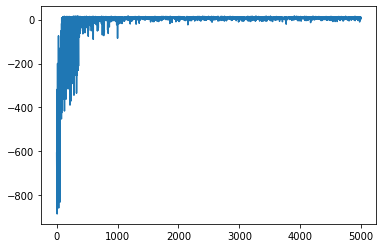

In [41]:
agent = SARSALambdaAgent(env)

# 训练
episodes = 5000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_sarsa(env, agent, train=False) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))